# Define dataset and Initital Scaling

In [1]:
%matplotlib inline

In [2]:
import pickle
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; sns.set_context('notebook')
from datetime import datetime
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
Characterisation_Set = pickle.load(open("Battery_Data/new_battery_cycles/Characterisation_Set_Complete.p", 'rb'))

def scale(X, torch=False):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    if torch:
        raise Exception("Not implement yet")
    else:
        X_min = X.min()
        X_max = X.max()
        
    return (X - X_min)/(X_max - X_min), X_min, X_max   

In [4]:
def scale_prior(X, X_min, X_max):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X_min)/(X_max - X_min)   

In [5]:
SoC, SoC_min, SoC_max = scale(Characterisation_Set["SoC"].T)
Current, Current_min, Current_max = scale(Characterisation_Set["Current"].T)
# Voltage, Voltage_min, Voltage_max = scale(Characterisation_Set["Voltage"].T)
Voltage = Characterisation_Set["Voltage"].T
Characterisation_Set["preprocessing"] = {
    "SoC": (SoC_max, SoC_min),
    "Current": (Current_max, Current_min)
}

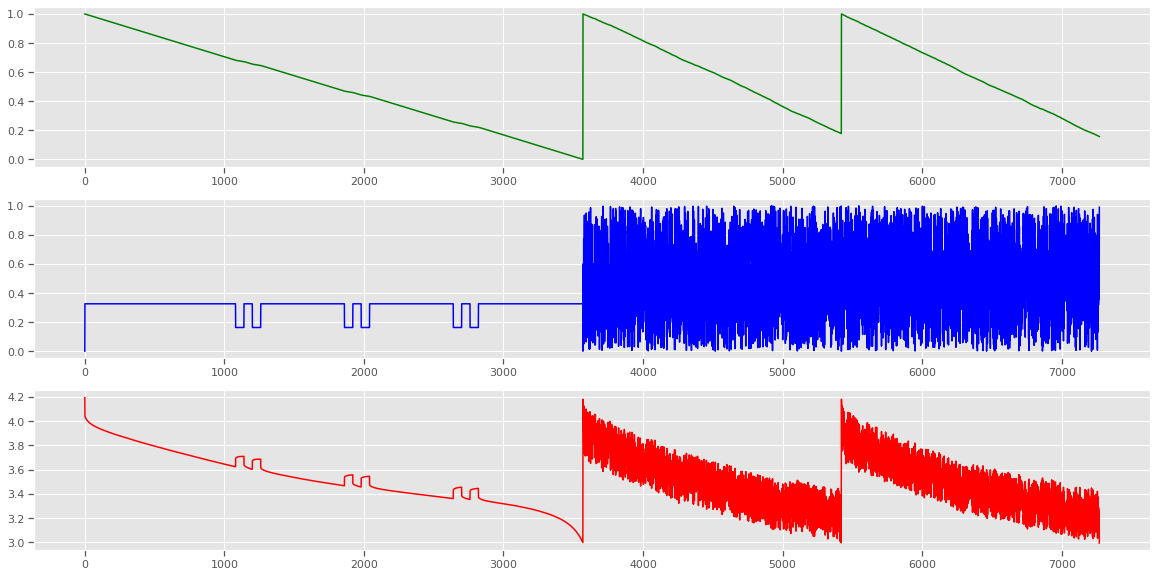

In [6]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
plt.figure("Characterisation_Set")
plt.subplot(311)
plt.plot(SoC, '-g')
plt.subplot(312)
plt.plot(Current, '-b')
plt.subplot(313)
plt.plot(Voltage, '-r')
plt.show()

## 2. Create a Prior for the network

In [7]:
prior_set = Characterisation_Set['Sets'][0]
SoC_prior_out = scale_prior(prior_set['SoC'].T, SoC_min, SoC_max)
Current_prior = scale_prior(prior_set['Current'].T, Current_min, Current_max)
Voltage_prior = prior_set['Voltage'].T

In [8]:
SoC_prior_in = np.concatenate(([[1.0]], SoC_prior_out[0:-1]))

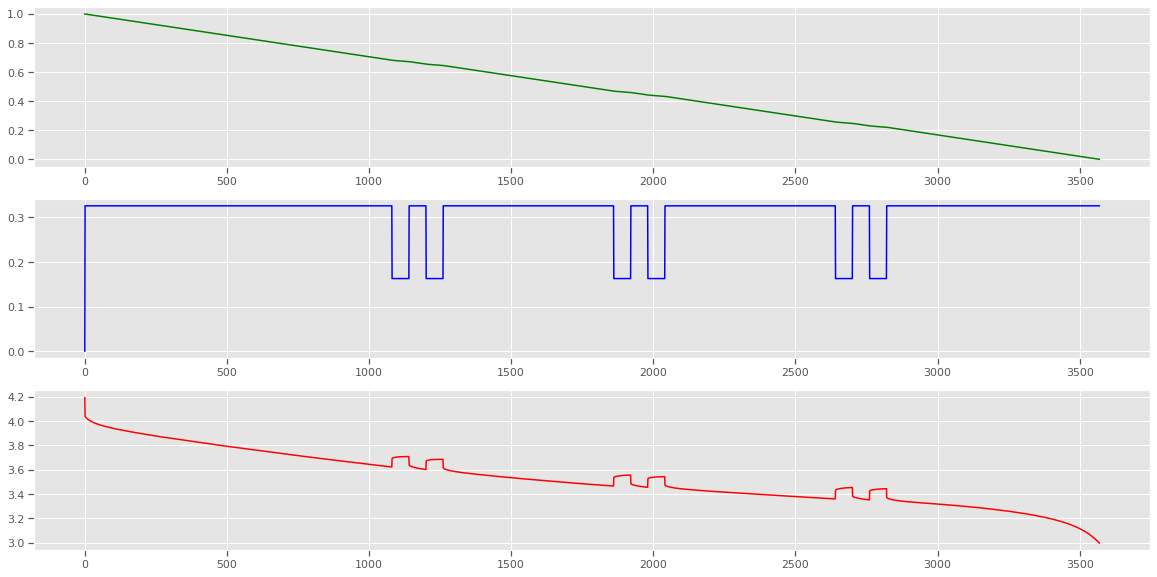

In [9]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
plt.figure("Characterisation_Set")
plt.subplot(311)
plt.plot(SoC_prior_out, '-g')
plt.subplot(312)
plt.plot(Current_prior, '-b')
plt.subplot(313)
plt.plot(Voltage_prior, '-r')
plt.show()

In [10]:
class Pretrain_Network(nn.Module):
    def __init__(self, p=0.25):
        super(Pretrain_Network, self).__init__()
        self.p = p
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)
        
        self.Voc_hl1 = nn.Linear(1, 1024)
        self.Voc_hl2 = nn.Linear(1024, 512)
        self.VoC = nn.Linear(512, 1)
                
    def forward(self, soc, current):
        voltage = torch.empty(current.shape, dtype=torch.float)
        soc_hist = torch.empty(current.shape, dtype=torch.float)
        for t in range(current.shape[1]):
            I = torch.Tensor([[current[t, 0]]])
            I = I.to(device, torch.float)
            soc_in = torch.Tensor([[soc[t, 0]]])
            soc_in = soc_in.to(device, torch.float)
            # Estimate VoC
            VoC = torch.sigmoid(self.Voc_hl1(soc_in))
            VoC = F.dropout(VoC, training=self.training, p=self.p)
            VoC = torch.sigmoid(self.Voc_hl2(VoC))
            VoC = F.dropout(VoC, training=self.training, p=self.p)
            VoC = self.VoC(VoC)

            # Estimate Z_p
            combined = torch.cat((soc_in, I), 1)
            Z = torch.sigmoid(self.Z_hl1(combined))
            Z = F.dropout(Z, training=self.training, p=self.p)
            Z = torch.sigmoid(self.Z_hl2(Z))
            Z = F.dropout(Z, training=self.training, p=self.p)
            Z = self.Z_p(Z)

            # Estimate V
            scaled_I = I*(Current_max - Current_min) + Current_min
            V = VoC - scaled_I*Z
            voltage[0, t] = V

            # Predict SoC
            soc = soc_in - scaled_I*V/Characterisation_Set['E_crit']
            soc_hist[0, t] = soc
        
        return voltage, soc_hist
    

In [11]:
prior = Pretrain_Network()
# init
for W in prior.parameters():
    nn.init.normal_(W)

# Loss and optimizer
criterion1 = nn.MSELoss()# Mean Squared Loss
criterion2 = nn.MSELoss()
# The weight_decay option implements L2 regularisation
optimizer = optim.Adam(prior.parameters(), weight_decay=0.00025) 

In [12]:
# Train the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
prior.to(device)

cuda:0


Pretrain_Network(
  (Z_hl1): Linear(in_features=2, out_features=1024, bias=True)
  (Z_hl2): Linear(in_features=1024, out_features=512, bias=True)
  (Z_p): Linear(in_features=512, out_features=1, bias=True)
  (Voc_hl1): Linear(in_features=1, out_features=1024, bias=True)
  (Voc_hl2): Linear(in_features=1024, out_features=512, bias=True)
  (VoC): Linear(in_features=512, out_features=1, bias=True)
)

In [13]:
import time
import math

epochs = 10000
running_loss = 0.0
loss_min = 1e10
loss_hist = []
    
prior.train()
start = time.time()

def timeSince(since):
    now = time.time()
    interval = now - since
    m = math.floor(interval / 60)
    s = interval - m * 60
    return '%dm %ds' % (m, s), now, interval

for epoch in range(epochs):
    count = -1
    avg_loss = 0
    
    V = torch.from_numpy(Voltage_prior).float()
    optimizer.zero_grad()
    V_est, SoC_est = prior(SoC_prior_in, Current_prior)
    loss_V = criterion1(V_est, V)
    SoC_real = torch.from_numpy(SoC_prior_out).float()
    loss_SoC = criterion2(SoC_est, SoC_real)
    loss = loss_SoC + loss_V
    loss.backward()
    optimizer.step()
    avg_loss += loss.item()
    loss_hist.append(loss.item())
    if epoch % 5 == 0:
        now_string, now, interval = timeSince(start)
        remaining_epochs = epochs-(epoch+1)
        remaining_time = interval*remaining_epochs/(epoch + 1)
        h_f = remaining_time / 60.0 / 60.0
        h = math.floor(h_f)
        m_f = (h_f - h)*60.0
        m = math.floor(m_f)
        s = (m_f - m)*60.0
        remaining_string = '%dh %dm %ds' % (h, m, s)
        print("epoch {}, time since start: {}, estimated remaining time: {}".format(epoch, now_string, remaining_string))
    if avg_loss < loss_min:
        print("New average minimum: ", avg_loss)
        torch.save(prior.state_dict(), "./Battery_Data/new_battery_cycles/Battery_RNN_prior_v2_test.mdl")
        loss_min = avg_loss

epoch 0, time since start: 0m 0s, estimated remaining time: 0h 11m 47s
epoch 5, time since start: 0m 0s, estimated remaining time: 0h 2m 18s
epoch 10, time since start: 0m 0s, estimated remaining time: 0h 1m 26s
epoch 15, time since start: 0m 0s, estimated remaining time: 0h 1m 6s
epoch 20, time since start: 0m 0s, estimated remaining time: 0h 0m 56s
epoch 25, time since start: 0m 0s, estimated remaining time: 0h 0m 50s
epoch 30, time since start: 0m 0s, estimated remaining time: 0h 0m 46s
epoch 35, time since start: 0m 0s, estimated remaining time: 0h 0m 42s
epoch 40, time since start: 0m 0s, estimated remaining time: 0h 0m 40s
epoch 45, time since start: 0m 0s, estimated remaining time: 0h 0m 38s
epoch 50, time since start: 0m 0s, estimated remaining time: 0h 0m 37s
epoch 55, time since start: 0m 0s, estimated remaining time: 0h 0m 35s
epoch 60, time since start: 0m 0s, estimated remaining time: 0h 0m 34s
epoch 65, time since start: 0m 0s, estimated remaining time: 0h 0m 33s
epoch 70

epoch 625, time since start: 0m 1s, estimated remaining time: 0h 0m 25s
epoch 630, time since start: 0m 1s, estimated remaining time: 0h 0m 25s
epoch 635, time since start: 0m 1s, estimated remaining time: 0h 0m 25s
epoch 640, time since start: 0m 1s, estimated remaining time: 0h 0m 25s
epoch 645, time since start: 0m 1s, estimated remaining time: 0h 0m 25s
epoch 650, time since start: 0m 1s, estimated remaining time: 0h 0m 25s
epoch 655, time since start: 0m 1s, estimated remaining time: 0h 0m 25s
epoch 660, time since start: 0m 1s, estimated remaining time: 0h 0m 25s
epoch 665, time since start: 0m 1s, estimated remaining time: 0h 0m 25s
epoch 670, time since start: 0m 1s, estimated remaining time: 0h 0m 25s
epoch 675, time since start: 0m 1s, estimated remaining time: 0h 0m 25s
epoch 680, time since start: 0m 1s, estimated remaining time: 0h 0m 25s
epoch 685, time since start: 0m 1s, estimated remaining time: 0h 0m 24s
epoch 690, time since start: 0m 1s, estimated remaining time: 0h

epoch 1220, time since start: 0m 3s, estimated remaining time: 0h 0m 22s
epoch 1225, time since start: 0m 3s, estimated remaining time: 0h 0m 22s
epoch 1230, time since start: 0m 3s, estimated remaining time: 0h 0m 22s
epoch 1235, time since start: 0m 3s, estimated remaining time: 0h 0m 22s
epoch 1240, time since start: 0m 3s, estimated remaining time: 0h 0m 22s
epoch 1245, time since start: 0m 3s, estimated remaining time: 0h 0m 22s
epoch 1250, time since start: 0m 3s, estimated remaining time: 0h 0m 22s
epoch 1255, time since start: 0m 3s, estimated remaining time: 0h 0m 22s
epoch 1260, time since start: 0m 3s, estimated remaining time: 0h 0m 22s
epoch 1265, time since start: 0m 3s, estimated remaining time: 0h 0m 22s
epoch 1270, time since start: 0m 3s, estimated remaining time: 0h 0m 22s
epoch 1275, time since start: 0m 3s, estimated remaining time: 0h 0m 22s
epoch 1280, time since start: 0m 3s, estimated remaining time: 0h 0m 22s
epoch 1285, time since start: 0m 3s, estimated rema

epoch 1830, time since start: 0m 4s, estimated remaining time: 0h 0m 20s
epoch 1835, time since start: 0m 4s, estimated remaining time: 0h 0m 20s
epoch 1840, time since start: 0m 4s, estimated remaining time: 0h 0m 20s
epoch 1845, time since start: 0m 4s, estimated remaining time: 0h 0m 20s
epoch 1850, time since start: 0m 4s, estimated remaining time: 0h 0m 20s
epoch 1855, time since start: 0m 4s, estimated remaining time: 0h 0m 20s
epoch 1860, time since start: 0m 4s, estimated remaining time: 0h 0m 20s
epoch 1865, time since start: 0m 4s, estimated remaining time: 0h 0m 20s
epoch 1870, time since start: 0m 4s, estimated remaining time: 0h 0m 20s
epoch 1875, time since start: 0m 4s, estimated remaining time: 0h 0m 20s
epoch 1880, time since start: 0m 4s, estimated remaining time: 0h 0m 20s
epoch 1885, time since start: 0m 4s, estimated remaining time: 0h 0m 20s
epoch 1890, time since start: 0m 4s, estimated remaining time: 0h 0m 20s
epoch 1895, time since start: 0m 4s, estimated rema

epoch 2430, time since start: 0m 6s, estimated remaining time: 0h 0m 18s
epoch 2435, time since start: 0m 6s, estimated remaining time: 0h 0m 18s
epoch 2440, time since start: 0m 6s, estimated remaining time: 0h 0m 18s
epoch 2445, time since start: 0m 6s, estimated remaining time: 0h 0m 18s
epoch 2450, time since start: 0m 6s, estimated remaining time: 0h 0m 18s
epoch 2455, time since start: 0m 6s, estimated remaining time: 0h 0m 18s
epoch 2460, time since start: 0m 6s, estimated remaining time: 0h 0m 18s
epoch 2465, time since start: 0m 6s, estimated remaining time: 0h 0m 18s
epoch 2470, time since start: 0m 6s, estimated remaining time: 0h 0m 18s
epoch 2475, time since start: 0m 6s, estimated remaining time: 0h 0m 18s
epoch 2480, time since start: 0m 6s, estimated remaining time: 0h 0m 18s
epoch 2485, time since start: 0m 6s, estimated remaining time: 0h 0m 18s
epoch 2490, time since start: 0m 6s, estimated remaining time: 0h 0m 18s
epoch 2495, time since start: 0m 6s, estimated rema

epoch 3015, time since start: 0m 7s, estimated remaining time: 0h 0m 17s
epoch 3020, time since start: 0m 7s, estimated remaining time: 0h 0m 17s
epoch 3025, time since start: 0m 7s, estimated remaining time: 0h 0m 17s
epoch 3030, time since start: 0m 7s, estimated remaining time: 0h 0m 17s
epoch 3035, time since start: 0m 7s, estimated remaining time: 0h 0m 17s
epoch 3040, time since start: 0m 7s, estimated remaining time: 0h 0m 17s
epoch 3045, time since start: 0m 7s, estimated remaining time: 0h 0m 17s
epoch 3050, time since start: 0m 7s, estimated remaining time: 0h 0m 17s
epoch 3055, time since start: 0m 7s, estimated remaining time: 0h 0m 17s
epoch 3060, time since start: 0m 7s, estimated remaining time: 0h 0m 17s
epoch 3065, time since start: 0m 7s, estimated remaining time: 0h 0m 17s
epoch 3070, time since start: 0m 7s, estimated remaining time: 0h 0m 17s
epoch 3075, time since start: 0m 7s, estimated remaining time: 0h 0m 17s
epoch 3080, time since start: 0m 7s, estimated rema

epoch 3605, time since start: 0m 8s, estimated remaining time: 0h 0m 15s
epoch 3610, time since start: 0m 8s, estimated remaining time: 0h 0m 15s
epoch 3615, time since start: 0m 8s, estimated remaining time: 0h 0m 15s
epoch 3620, time since start: 0m 8s, estimated remaining time: 0h 0m 15s
epoch 3625, time since start: 0m 8s, estimated remaining time: 0h 0m 15s
epoch 3630, time since start: 0m 8s, estimated remaining time: 0h 0m 15s
epoch 3635, time since start: 0m 8s, estimated remaining time: 0h 0m 15s
epoch 3640, time since start: 0m 9s, estimated remaining time: 0h 0m 15s
epoch 3645, time since start: 0m 9s, estimated remaining time: 0h 0m 15s
epoch 3650, time since start: 0m 9s, estimated remaining time: 0h 0m 15s
epoch 3655, time since start: 0m 9s, estimated remaining time: 0h 0m 15s
epoch 3660, time since start: 0m 9s, estimated remaining time: 0h 0m 15s
epoch 3665, time since start: 0m 9s, estimated remaining time: 0h 0m 15s
epoch 3670, time since start: 0m 9s, estimated rema

epoch 4200, time since start: 0m 10s, estimated remaining time: 0h 0m 14s
epoch 4205, time since start: 0m 10s, estimated remaining time: 0h 0m 14s
epoch 4210, time since start: 0m 10s, estimated remaining time: 0h 0m 14s
epoch 4215, time since start: 0m 10s, estimated remaining time: 0h 0m 14s
epoch 4220, time since start: 0m 10s, estimated remaining time: 0h 0m 14s
epoch 4225, time since start: 0m 10s, estimated remaining time: 0h 0m 14s
epoch 4230, time since start: 0m 10s, estimated remaining time: 0h 0m 14s
epoch 4235, time since start: 0m 10s, estimated remaining time: 0h 0m 14s
epoch 4240, time since start: 0m 10s, estimated remaining time: 0h 0m 14s
epoch 4245, time since start: 0m 10s, estimated remaining time: 0h 0m 14s
epoch 4250, time since start: 0m 10s, estimated remaining time: 0h 0m 14s
epoch 4255, time since start: 0m 10s, estimated remaining time: 0h 0m 14s
epoch 4260, time since start: 0m 10s, estimated remaining time: 0h 0m 14s
epoch 4265, time since start: 0m 10s, 

epoch 4805, time since start: 0m 11s, estimated remaining time: 0h 0m 12s
epoch 4810, time since start: 0m 11s, estimated remaining time: 0h 0m 12s
epoch 4815, time since start: 0m 11s, estimated remaining time: 0h 0m 12s
epoch 4820, time since start: 0m 11s, estimated remaining time: 0h 0m 12s
epoch 4825, time since start: 0m 11s, estimated remaining time: 0h 0m 12s
epoch 4830, time since start: 0m 11s, estimated remaining time: 0h 0m 12s
epoch 4835, time since start: 0m 11s, estimated remaining time: 0h 0m 12s
epoch 4840, time since start: 0m 11s, estimated remaining time: 0h 0m 12s
epoch 4845, time since start: 0m 11s, estimated remaining time: 0h 0m 12s
epoch 4850, time since start: 0m 11s, estimated remaining time: 0h 0m 12s
epoch 4855, time since start: 0m 11s, estimated remaining time: 0h 0m 12s
epoch 4860, time since start: 0m 11s, estimated remaining time: 0h 0m 12s
epoch 4865, time since start: 0m 11s, estimated remaining time: 0h 0m 12s
epoch 4870, time since start: 0m 11s, 

epoch 5400, time since start: 0m 13s, estimated remaining time: 0h 0m 11s
epoch 5405, time since start: 0m 13s, estimated remaining time: 0h 0m 11s
epoch 5410, time since start: 0m 13s, estimated remaining time: 0h 0m 11s
epoch 5415, time since start: 0m 13s, estimated remaining time: 0h 0m 11s
epoch 5420, time since start: 0m 13s, estimated remaining time: 0h 0m 11s
epoch 5425, time since start: 0m 13s, estimated remaining time: 0h 0m 11s
epoch 5430, time since start: 0m 13s, estimated remaining time: 0h 0m 11s
epoch 5435, time since start: 0m 13s, estimated remaining time: 0h 0m 11s
epoch 5440, time since start: 0m 13s, estimated remaining time: 0h 0m 11s
epoch 5445, time since start: 0m 13s, estimated remaining time: 0h 0m 11s
epoch 5450, time since start: 0m 13s, estimated remaining time: 0h 0m 11s
epoch 5455, time since start: 0m 13s, estimated remaining time: 0h 0m 11s
epoch 5460, time since start: 0m 13s, estimated remaining time: 0h 0m 11s
epoch 5465, time since start: 0m 13s, 

epoch 5995, time since start: 0m 14s, estimated remaining time: 0h 0m 9s
epoch 6000, time since start: 0m 14s, estimated remaining time: 0h 0m 9s
epoch 6005, time since start: 0m 14s, estimated remaining time: 0h 0m 9s
epoch 6010, time since start: 0m 14s, estimated remaining time: 0h 0m 9s
epoch 6015, time since start: 0m 14s, estimated remaining time: 0h 0m 9s
epoch 6020, time since start: 0m 14s, estimated remaining time: 0h 0m 9s
epoch 6025, time since start: 0m 14s, estimated remaining time: 0h 0m 9s
epoch 6030, time since start: 0m 14s, estimated remaining time: 0h 0m 9s
epoch 6035, time since start: 0m 14s, estimated remaining time: 0h 0m 9s
epoch 6040, time since start: 0m 14s, estimated remaining time: 0h 0m 9s
epoch 6045, time since start: 0m 14s, estimated remaining time: 0h 0m 9s
epoch 6050, time since start: 0m 14s, estimated remaining time: 0h 0m 9s
epoch 6055, time since start: 0m 14s, estimated remaining time: 0h 0m 9s
epoch 6060, time since start: 0m 14s, estimated rem

epoch 6595, time since start: 0m 16s, estimated remaining time: 0h 0m 8s
epoch 6600, time since start: 0m 16s, estimated remaining time: 0h 0m 8s
epoch 6605, time since start: 0m 16s, estimated remaining time: 0h 0m 8s
epoch 6610, time since start: 0m 16s, estimated remaining time: 0h 0m 8s
epoch 6615, time since start: 0m 16s, estimated remaining time: 0h 0m 8s
epoch 6620, time since start: 0m 16s, estimated remaining time: 0h 0m 8s
epoch 6625, time since start: 0m 16s, estimated remaining time: 0h 0m 8s
epoch 6630, time since start: 0m 16s, estimated remaining time: 0h 0m 8s
epoch 6635, time since start: 0m 16s, estimated remaining time: 0h 0m 8s
epoch 6640, time since start: 0m 16s, estimated remaining time: 0h 0m 8s
epoch 6645, time since start: 0m 16s, estimated remaining time: 0h 0m 8s
epoch 6650, time since start: 0m 16s, estimated remaining time: 0h 0m 8s
epoch 6655, time since start: 0m 16s, estimated remaining time: 0h 0m 8s
epoch 6660, time since start: 0m 16s, estimated rem

epoch 7190, time since start: 0m 17s, estimated remaining time: 0h 0m 6s
epoch 7195, time since start: 0m 17s, estimated remaining time: 0h 0m 6s
epoch 7200, time since start: 0m 17s, estimated remaining time: 0h 0m 6s
epoch 7205, time since start: 0m 17s, estimated remaining time: 0h 0m 6s
epoch 7210, time since start: 0m 17s, estimated remaining time: 0h 0m 6s
epoch 7215, time since start: 0m 17s, estimated remaining time: 0h 0m 6s
epoch 7220, time since start: 0m 17s, estimated remaining time: 0h 0m 6s
epoch 7225, time since start: 0m 17s, estimated remaining time: 0h 0m 6s
epoch 7230, time since start: 0m 17s, estimated remaining time: 0h 0m 6s
epoch 7235, time since start: 0m 17s, estimated remaining time: 0h 0m 6s
epoch 7240, time since start: 0m 17s, estimated remaining time: 0h 0m 6s
epoch 7245, time since start: 0m 17s, estimated remaining time: 0h 0m 6s
epoch 7250, time since start: 0m 17s, estimated remaining time: 0h 0m 6s
epoch 7255, time since start: 0m 17s, estimated rem

epoch 7785, time since start: 0m 18s, estimated remaining time: 0h 0m 5s
epoch 7790, time since start: 0m 18s, estimated remaining time: 0h 0m 5s
epoch 7795, time since start: 0m 18s, estimated remaining time: 0h 0m 5s
epoch 7800, time since start: 0m 19s, estimated remaining time: 0h 0m 5s
epoch 7805, time since start: 0m 19s, estimated remaining time: 0h 0m 5s
epoch 7810, time since start: 0m 19s, estimated remaining time: 0h 0m 5s
epoch 7815, time since start: 0m 19s, estimated remaining time: 0h 0m 5s
epoch 7820, time since start: 0m 19s, estimated remaining time: 0h 0m 5s
epoch 7825, time since start: 0m 19s, estimated remaining time: 0h 0m 5s
epoch 7830, time since start: 0m 19s, estimated remaining time: 0h 0m 5s
epoch 7835, time since start: 0m 19s, estimated remaining time: 0h 0m 5s
epoch 7840, time since start: 0m 19s, estimated remaining time: 0h 0m 5s
epoch 7845, time since start: 0m 19s, estimated remaining time: 0h 0m 5s
epoch 7850, time since start: 0m 19s, estimated rem

epoch 8380, time since start: 0m 20s, estimated remaining time: 0h 0m 3s
epoch 8385, time since start: 0m 20s, estimated remaining time: 0h 0m 3s
epoch 8390, time since start: 0m 20s, estimated remaining time: 0h 0m 3s
epoch 8395, time since start: 0m 20s, estimated remaining time: 0h 0m 3s
epoch 8400, time since start: 0m 20s, estimated remaining time: 0h 0m 3s
epoch 8405, time since start: 0m 20s, estimated remaining time: 0h 0m 3s
epoch 8410, time since start: 0m 20s, estimated remaining time: 0h 0m 3s
epoch 8415, time since start: 0m 20s, estimated remaining time: 0h 0m 3s
epoch 8420, time since start: 0m 20s, estimated remaining time: 0h 0m 3s
epoch 8425, time since start: 0m 20s, estimated remaining time: 0h 0m 3s
epoch 8430, time since start: 0m 20s, estimated remaining time: 0h 0m 3s
epoch 8435, time since start: 0m 20s, estimated remaining time: 0h 0m 3s
epoch 8440, time since start: 0m 20s, estimated remaining time: 0h 0m 3s
epoch 8445, time since start: 0m 20s, estimated rem

epoch 8985, time since start: 0m 21s, estimated remaining time: 0h 0m 2s
epoch 8990, time since start: 0m 21s, estimated remaining time: 0h 0m 2s
epoch 8995, time since start: 0m 21s, estimated remaining time: 0h 0m 2s
epoch 9000, time since start: 0m 21s, estimated remaining time: 0h 0m 2s
epoch 9005, time since start: 0m 21s, estimated remaining time: 0h 0m 2s
epoch 9010, time since start: 0m 21s, estimated remaining time: 0h 0m 2s
epoch 9015, time since start: 0m 21s, estimated remaining time: 0h 0m 2s
epoch 9020, time since start: 0m 21s, estimated remaining time: 0h 0m 2s
epoch 9025, time since start: 0m 21s, estimated remaining time: 0h 0m 2s
epoch 9030, time since start: 0m 21s, estimated remaining time: 0h 0m 2s
epoch 9035, time since start: 0m 21s, estimated remaining time: 0h 0m 2s
epoch 9040, time since start: 0m 21s, estimated remaining time: 0h 0m 2s
epoch 9045, time since start: 0m 22s, estimated remaining time: 0h 0m 2s
epoch 9050, time since start: 0m 22s, estimated rem

epoch 9580, time since start: 0m 23s, estimated remaining time: 0h 0m 1s
epoch 9585, time since start: 0m 23s, estimated remaining time: 0h 0m 1s
epoch 9590, time since start: 0m 23s, estimated remaining time: 0h 0m 0s
epoch 9595, time since start: 0m 23s, estimated remaining time: 0h 0m 0s
epoch 9600, time since start: 0m 23s, estimated remaining time: 0h 0m 0s
epoch 9605, time since start: 0m 23s, estimated remaining time: 0h 0m 0s
epoch 9610, time since start: 0m 23s, estimated remaining time: 0h 0m 0s
epoch 9615, time since start: 0m 23s, estimated remaining time: 0h 0m 0s
epoch 9620, time since start: 0m 23s, estimated remaining time: 0h 0m 0s
epoch 9625, time since start: 0m 23s, estimated remaining time: 0h 0m 0s
epoch 9630, time since start: 0m 23s, estimated remaining time: 0h 0m 0s
epoch 9635, time since start: 0m 23s, estimated remaining time: 0h 0m 0s
epoch 9640, time since start: 0m 23s, estimated remaining time: 0h 0m 0s
epoch 9645, time since start: 0m 23s, estimated rem

## 3. Train Network

In [14]:
class Battery_RNN(nn.Module):
    def __init__(self, p=0.25):
        super(Battery_RNN, self).__init__()
        self.p = p
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)
        
        self.Voc_hl1 = nn.Linear(1, 1024)
        self.Voc_hl2 = nn.Linear(1024, 512)
        self.VoC = nn.Linear(512, 1)
                
    def forward(self, soc_init, current):
        
        voltage = torch.empty(current.shape, dtype=torch.float)
        soc_hist = torch.empty(current.shape, dtype=torch.float)
        soc = torch.Tensor([[soc_init]])
        soc = soc.to(device, torch.float)
        for t in range(current.shape[1]):
            I = torch.Tensor([[current[0, t]]])
            I = I.to(device, torch.float)
            # Estimate VoC
            VoC = torch.sigmoid(self.Voc_hl1(soc))
            VoC = F.dropout(VoC, training=self.training, p=self.p)
            VoC = torch.sigmoid(self.Voc_hl2(VoC))
            VoC = F.dropout(VoC, training=self.training, p=self.p)
            VoC = self.VoC(VoC)

            # Estimate Z_p
            combined = torch.cat((soc, I), 1)
            Z = torch.sigmoid(self.Z_hl1(combined))
            Z = F.dropout(Z, training=self.training, p=self.p)
            Z = torch.sigmoid(self.Z_hl2(Z))
            Z = F.dropout(Z, training=self.training, p=self.p)
            Z = self.Z_p(Z)

            # Estimate V
            scaled_I = I*(Current_max - Current_min) + Current_min
            V = VoC - scaled_I*Z
            voltage[0, t] = V

            # Predict SoC
            soc = soc - scaled_I*V/Characterisation_Set['E_crit']
            soc_hist[0, t] = soc
        
        return voltage, soc_hist

In [15]:
battery = Battery_RNN()

In [16]:
# init
for W in battery.parameters():
    nn.init.normal_(W)

In [17]:
# Loss and optimizer
criterion = nn.MSELoss()# Mean Squared Loss
# The weight_decay option implements L2 regularisation
optimizer = optim.Adam(battery.parameters(), weight_decay=0.00025) 

In [18]:
battery.to(device)

Battery_RNN(
  (Z_hl1): Linear(in_features=2, out_features=1024, bias=True)
  (Z_hl2): Linear(in_features=1024, out_features=512, bias=True)
  (Z_p): Linear(in_features=512, out_features=1, bias=True)
  (Voc_hl1): Linear(in_features=1, out_features=1024, bias=True)
  (Voc_hl2): Linear(in_features=1024, out_features=512, bias=True)
  (VoC): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
import time
import math

epochs = 5000
running_loss = 0.0
loss_min = 1e10
loss_hist = []
    
battery.train()
start = time.time()

def timeSince(since):
    now = time.time()
    interval = now - since
    m = math.floor(interval / 60)
    s = interval - m * 60
    return '%dm %ds' % (m, s), now, interval

for epoch in range(epochs):
    count = -1
    avg_loss = 0
    loss_set_hist = []
    
    for set_dict in Characterisation_Set['Sets']:
        count += 1
        V = torch.from_numpy(set_dict['Voltage']).float()
        optimizer.zero_grad()
        V_est, SoC = battery(set_dict['SoC'][0, 0], set_dict['Current'])
        loss = criterion(V_est, V)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        loss_set_hist.append(loss.item())
    loss_hist.append(loss_set_hist)
    avg_loss /= (count+1)
    if epoch % 5 == 0:
        now_string, now, interval = timeSince(start)
        remaining_epochs = epochs-(epoch+1)
        remaining_time = interval*remaining_epochs/(epoch + 1)
        h_f = remaining_time / 60.0 / 60.0
        h = math.floor(h_f)
        m_f = (h_f - h)*60.0
        m = math.floor(m_f)
        s = (m_f - m)*60.0
        remaining_string = '%dh %dm %ds' % (h, m, s)
        print("epoch {}, time since start: {}, estimated remaining time: {}".format(epoch, now_string, remaining_string))
    if avg_loss < loss_min:
        print("New average minimum: ", avg_loss)
        torch.save(battery.state_dict(), "./Battery_Data/new_battery_cycles/Battery_RNN_v3_test.mdl")
        loss_min = avg_loss
            

epoch 0, time since start: 0m 7s, estimated remaining time: 10h 34m 47s
New average minimum:  104193.62109375
New average minimum:  71057.13606770833


In [ ]:
battery = Battery_RNN()
battery.load_state_dict(torch.load("./Battery_Data/new_battery_cycles/Battery_RNN_v3_test.mdl"))
battery.to(device)
battery.eval()

with torch.no_grad():
    for i, set_dict in enumerate(Characterisation_Set['Sets']):
        
        V = torch.from_numpy(set_dict['Voltage']).float()
        V_est, SoC = battery(set_dict['SoC'][0, 0], set_dict['Current'])
        plt.figure(i)
        plt.subplot(2,1,1)
        plt.plot(set_dict['SoC'].T, 'k')
        plt.plot(SoC.to("cpu").numpy().T, 'g')
        plt.subplot(2,1,2)
        plt.plot(V.to("cpu").numpy().T, 'k')
        plt.plot(V_est.to("cpu").numpy().T, 'b')
        